# Q7.1: Self-Organizing Map (SOM) for Fraud Detection

Train a SOM, visualize the **U-Matrix (distance map)**, and tune key hyperparameters (grid size, learning rate).

**Exam outputs:** distance map, mapping/cluster visualization, and a brief tuning comparison (e.g., quantization error).

## Step 1: Install and Import Libraries

In [1]:
# Install minisom if not available
try:
    import minisom
except ImportError:
    import sys
    !{sys.executable} -m pip install minisom -q

import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification

print("Libraries imported")

  Preparing metadata (setup.py) ... done
Libraries imported


## Step 2: Generate Synthetic Credit Card Data

### Create Imbalanced Dataset (Fraud Detection)

In [2]:
# Generate synthetic credit card transaction data
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.97, 0.03],  # 3% fraud (imbalanced)
    random_state=42
)

print(f"Total samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Normal transactions: {np.sum(y == 0)}")
print(f"Fraudulent transactions: {np.sum(y == 1)}")
print(f"Fraud percentage: {np.sum(y == 1)/len(y)*100:.2f}%")

Total samples: 1000
Features: 20
Normal transactions: 967
Fraudulent transactions: 33
Fraud percentage: 3.30%


## Step 3: Normalize Data

In [3]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

print(f"Normalized data shape: {X_norm.shape}")
print(f"Min value: {X_norm.min():.2f}")
print(f"Max value: {X_norm.max():.2f}")

Normalized data shape: (1000, 20)
Min value: 0.00
Max value: 1.00


## Step 4: Train SOM with Default Hyperparameters

In [4]:
# SOM parameters
grid_size = 10
sigma = 1.0
lr = 0.5
n_iter = 1000

# Initialize SOM
som_default = MiniSom(x=grid_size, y=grid_size, input_len=X_norm.shape[1],
                      sigma=sigma, learning_rate=lr, random_seed=42)

# Initialize weights
som_default.random_weights_init(X_norm)

# Train
print(f"Training SOM (10x10, sigma={sigma}, lr={lr}, iterations={n_iter})...")
som_default.train_random(X_norm, n_iter)

print("Training complete!")

Training SOM (10x10, sigma=1.0, lr=0.5, iterations=1000)...
Training complete!


## Step 5: Visualize Distance Map (U-Matrix)

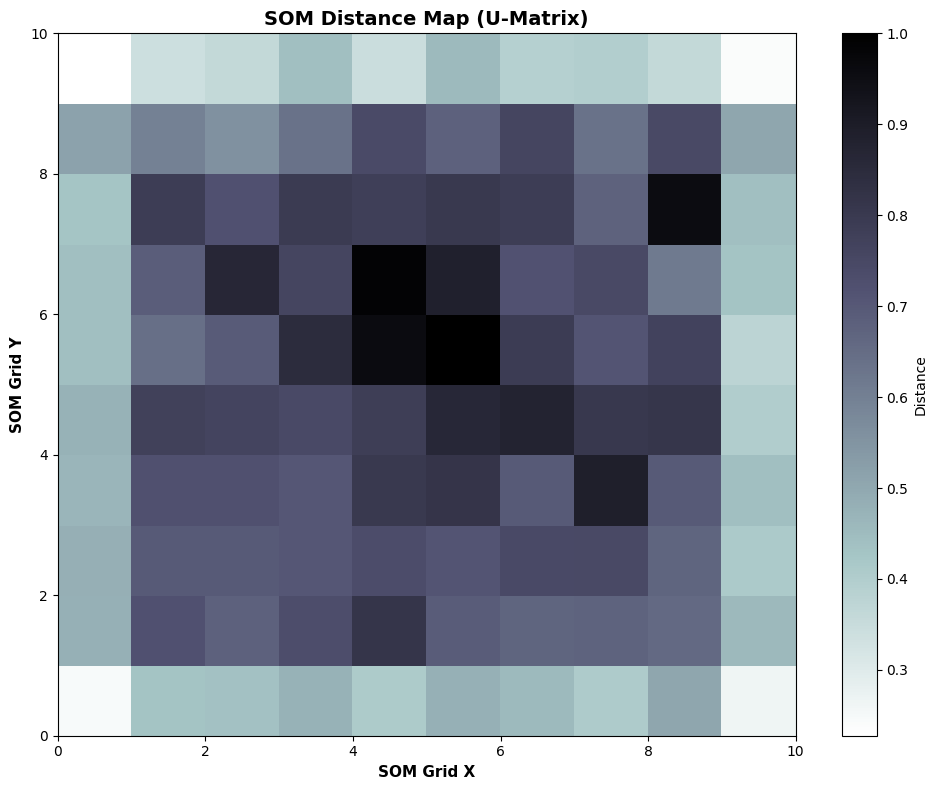

Light areas: similar neurons
Dark areas: cluster boundaries


In [5]:
# Calculate distance map
dist_map = som_default.distance_map()

plt.figure(figsize=(10, 8))
plt.pcolor(dist_map.T, cmap='bone_r')
plt.colorbar(label='Distance')
plt.title('SOM Distance Map (U-Matrix)', fontsize=14, fontweight='bold')
plt.xlabel('SOM Grid X', fontsize=11, fontweight='bold')
plt.ylabel('SOM Grid Y', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("Light areas: similar neurons")
print("Dark areas: cluster boundaries")

## Step 6: Map Data Points to SOM Grid

In [6]:
# Get winning neurons for each sample
win_map = {}
for i, x in enumerate(X_norm):
    w = som_default.winner(x)
    if w not in win_map:
        win_map[w] = []
    win_map[w].append((i, y[i]))

print(f"Number of active neurons: {len(win_map)}")
print(f"Total neurons: {grid_size * grid_size}")

Number of active neurons: 100
Total neurons: 100


## Step 7: Visualize Fraud vs Normal Transactions

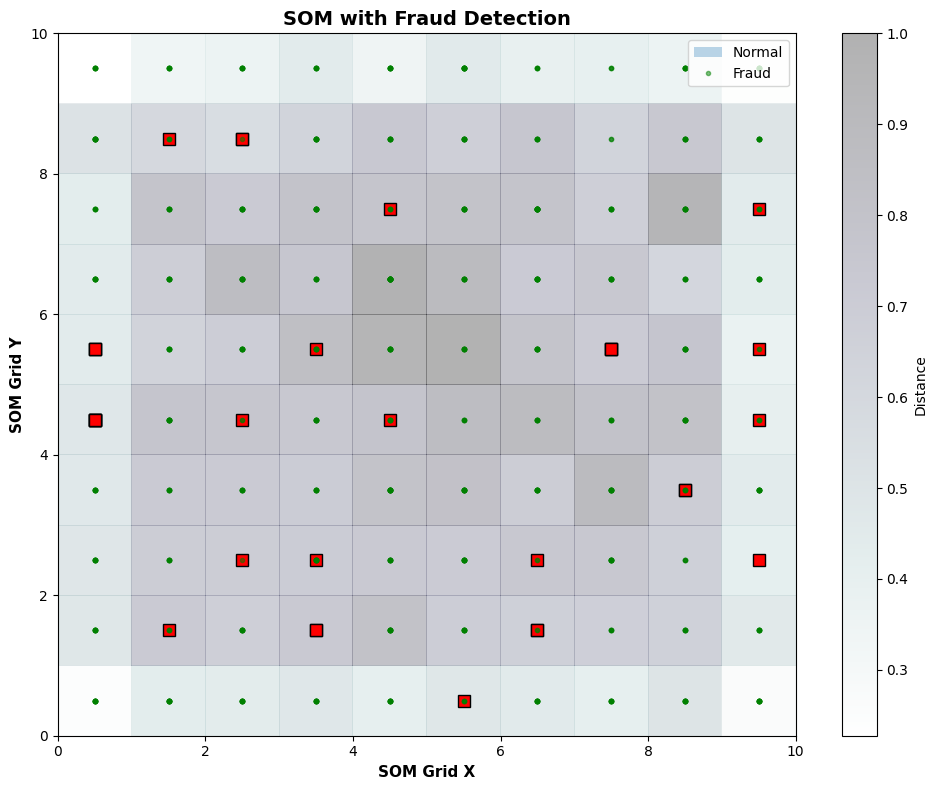

In [7]:
plt.figure(figsize=(10, 8))
plt.pcolor(dist_map.T, cmap='bone_r', alpha=0.3)
plt.colorbar(label='Distance')

# Plot markers
for i, x in enumerate(X_norm):
    w = som_default.winner(x)
    if y[i] == 0:  # Normal
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'go', markersize=3, alpha=0.5)
    else:  # Fraud
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'rs', markersize=8, markeredgecolor='black')

plt.title('SOM with Fraud Detection', fontsize=14, fontweight='bold')
plt.xlabel('SOM Grid X', fontsize=11, fontweight='bold')
plt.ylabel('SOM Grid Y', fontsize=11, fontweight='bold')
plt.legend(['Normal', 'Fraud'], loc='upper right')
plt.tight_layout()
plt.show()

## Step 8: Hyperparameter Tuning - Grid Size Comparison

In [8]:
grid_sizes = [5, 10, 15]
som_models = {}

for gs in grid_sizes:
    print(f"\nTraining SOM with grid size {gs}x{gs}...")

    som = MiniSom(x=gs, y=gs, input_len=X_norm.shape[1],
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(X_norm)
    som.train_random(X_norm, 1000)

    som_models[gs] = som

    # Calculate quantization error
    q_error = som.quantization_error(X_norm)
    print(f"Quantization Error: {q_error:.4f}")

print("\nGrid size comparison complete!")


Training SOM with grid size 5x5...
Quantization Error: 0.4982

Training SOM with grid size 10x10...
Quantization Error: 0.4140

Training SOM with grid size 15x15...
Quantization Error: 0.3763

Grid size comparison complete!


### Visualize Different Grid Sizes

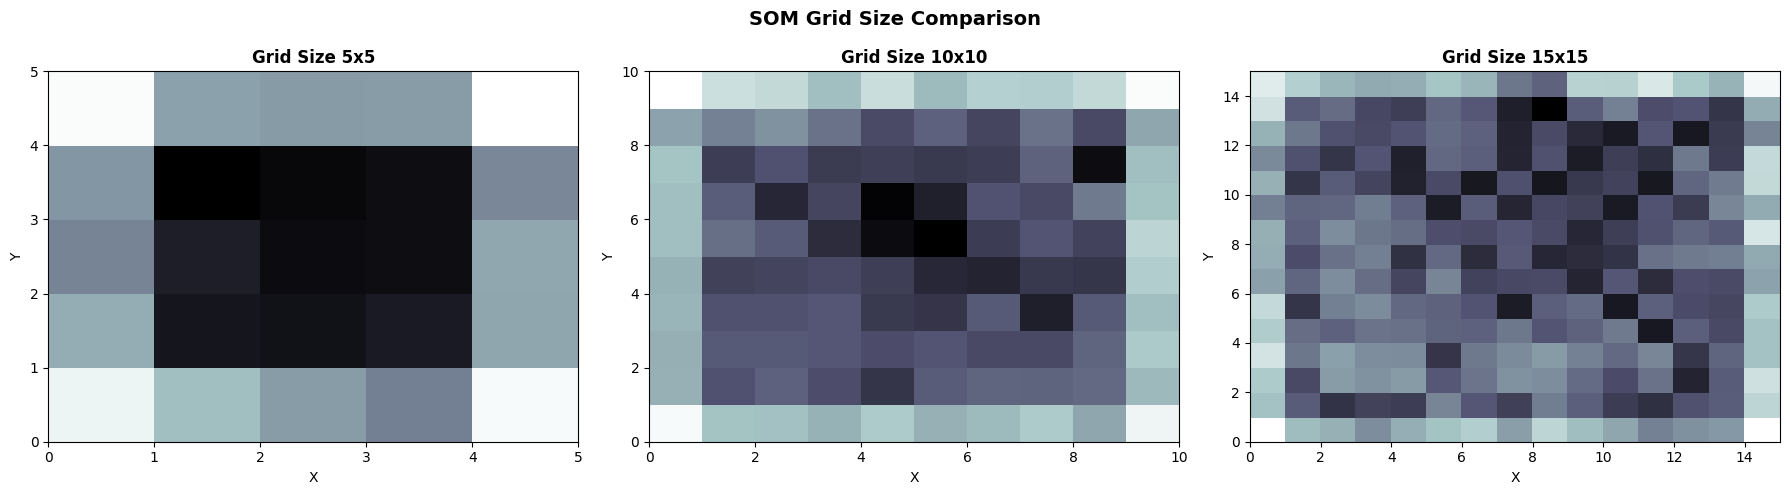

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, gs in enumerate(grid_sizes):
    som = som_models[gs]
    dist_map = som.distance_map()

    axes[idx].pcolor(dist_map.T, cmap='bone_r')
    axes[idx].set_title(f'Grid Size {gs}x{gs}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Y')

plt.suptitle('SOM Grid Size Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 9: Hyperparameter Tuning - Learning Rate Comparison

In [10]:
learning_rates = [0.1, 0.5, 0.9]
lr_errors = []

for lr in learning_rates:
    print(f"\nTraining SOM with lr={lr}...")

    som = MiniSom(x=10, y=10, input_len=X_norm.shape[1],
                  sigma=1.0, learning_rate=lr, random_seed=42)
    som.random_weights_init(X_norm)
    som.train_random(X_norm, 1000)

    q_error = som.quantization_error(X_norm)
    lr_errors.append(q_error)
    print(f"Quantization Error: {q_error:.4f}")

print("\nLearning rate comparison complete!")


Training SOM with lr=0.1...
Quantization Error: 0.4439

Training SOM with lr=0.5...
Quantization Error: 0.4140

Training SOM with lr=0.9...
Quantization Error: 0.4167

Learning rate comparison complete!


### Plot Learning Rate Comparison

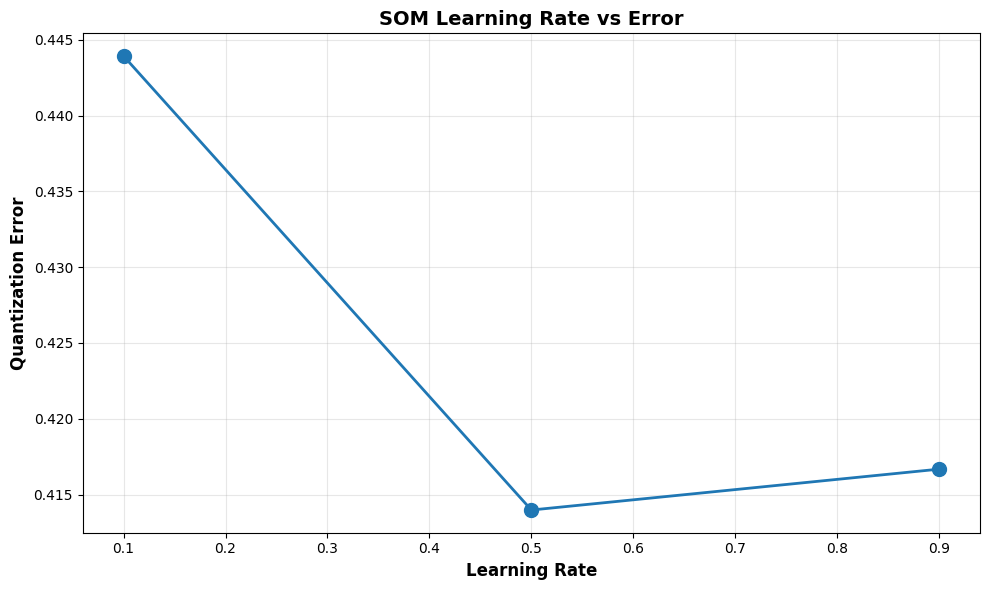

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, lr_errors, 'o-', linewidth=2, markersize=10)
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Quantization Error', fontsize=12, fontweight='bold')
plt.title('SOM Learning Rate vs Error', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 10: Identify Potential Fraud Clusters

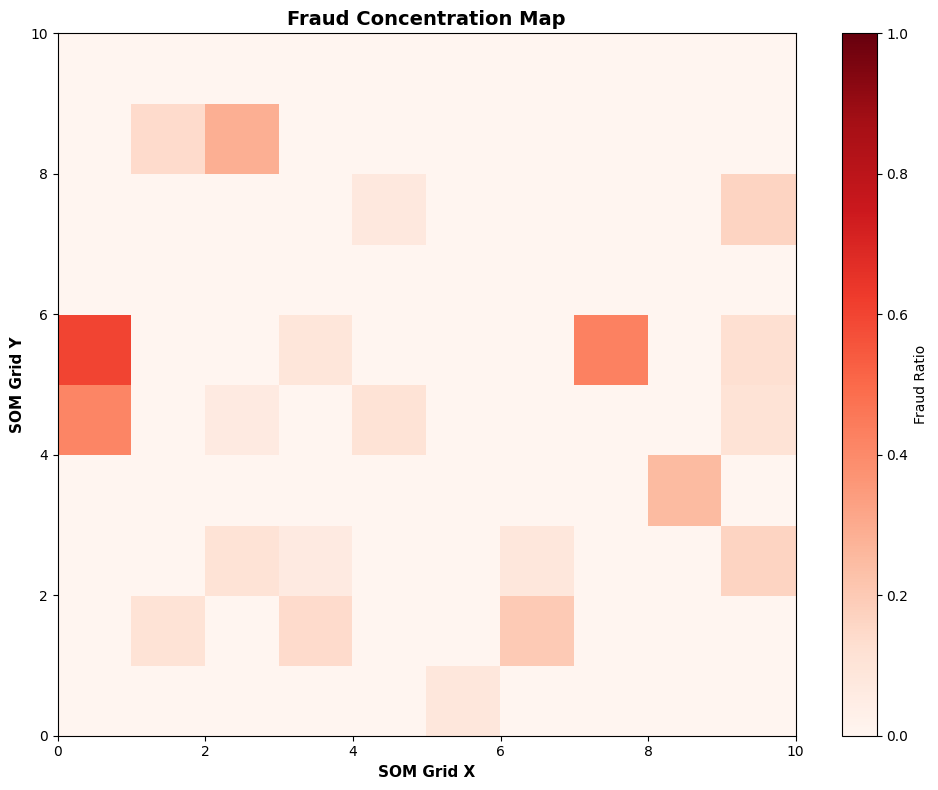

Red areas indicate high fraud concentration
White areas are mostly normal transactions


In [12]:
# Calculate fraud concentration per neuron
fraud_map = np.zeros((grid_size, grid_size))

for neuron, samples in win_map.items():
    fraud_count = sum([1 for _, label in samples if label == 1])
    total_count = len(samples)
    fraud_map[neuron] = fraud_count / total_count if total_count > 0 else 0

plt.figure(figsize=(10, 8))
plt.pcolor(fraud_map.T, cmap='Reds', vmin=0, vmax=1)
plt.colorbar(label='Fraud Ratio')
plt.title('Fraud Concentration Map', fontsize=14, fontweight='bold')
plt.xlabel('SOM Grid X', fontsize=11, fontweight='bold')
plt.ylabel('SOM Grid Y', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("Red areas indicate high fraud concentration")
print("White areas are mostly normal transactions")

## Step 11: Summary Statistics

In [13]:
print("\n=== SOM HYPERPARAMETER TUNING RESULTS ===")

print("\nGrid Size Comparison:")
for gs in grid_sizes:
    q_error = som_models[gs].quantization_error(X_norm)
    print(f"  {gs}x{gs}: Quantization Error = {q_error:.4f}")

print("\nLearning Rate Comparison:")
for lr, error in zip(learning_rates, lr_errors):
    print(f"  lr={lr}: Quantization Error = {error:.4f}")

print("\nFraud Detection Summary:")
fraud_neurons = np.sum(fraud_map > 0.5)
print(f"  Neurons with >50% fraud: {fraud_neurons}")
print(f"  Total active neurons: {len(win_map)}")
print(f"  Percentage: {fraud_neurons/len(win_map)*100:.2f}%")


=== SOM HYPERPARAMETER TUNING RESULTS ===

Grid Size Comparison:
  5x5: Quantization Error = 0.4982
  10x10: Quantization Error = 0.4140
  15x15: Quantization Error = 0.3763

Learning Rate Comparison:
  lr=0.1: Quantization Error = 0.4439
  lr=0.5: Quantization Error = 0.4140
  lr=0.9: Quantization Error = 0.4167

Fraud Detection Summary:
  Neurons with >50% fraud: 1
  Total active neurons: 100
  Percentage: 1.00%


## Summary

**Self-Organizing Map (SOM):**
- Unsupervised learning algorithm for dimensionality reduction and clustering
- Maps high-dimensional data to 2D grid while preserving topology

**Key Hyperparameters:**
1. **Grid Size**: Larger = more detail, smaller = faster training
2. **Learning Rate**: Controls adaptation speed (0.1-0.9)
3. **Sigma**: Neighborhood radius for winner neuron
4. **Iterations**: More iterations = better convergence

**Fraud Detection with SOM:**
- Fraudulent transactions cluster together
- Distance map shows cluster boundaries
- Red areas in fraud map indicate suspicious regions
- Can flag new transactions falling in fraud-heavy neurons